# SpikeInterface Tutorial -  SI new API (versio>0.90)  - Jul 2021


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. 
We will be using the new `spikeinterface` version (>0.90) from the SpikeInterface github organization. 

For this analysis, we will use a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is provided by Samuel McKenzie. We will show how to:

- load the data with extractor package
- load the probe information using ProbeInterface
- preprocess the signals using the toolkit module
- run a popular spike sorting algorithm with different parameters with the sorters module
- curate the spike sorting output using 1) quality metrics (automatic) - 2) [Phy](https://github.com/cortex-lab/phy) 
(manual) - 3) consensus-based

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Spike sorting comparison](#comparison)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Downloading the recording

First, we need to download the recording. Feel free to use your own recordings as well later on. 
From this Zenodo [link](https://doi.org/10.5281/zenodo.4657314), you can download the dataset mentioned above (`cambridge_data.bin`). Move the dataset in the current folder and unzip it.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Importing the modules

Let's now import the `spikeinterface` modules that we need.

In [152]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [2]:
# file path
recording_file = 'cambridge_data.bin'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype="int16"
time_axis = 1

In [3]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

In [ ]:
# explain
recording.annotate(is_filtered=False)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [4]:
print(recording)

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  files_path: ['/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/cambridge_data.bin']


While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [5]:
se.recording_extractor_full_list

[spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 spikeinterface.core.numpyextractors.NumpyRecording,
 spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 spikeinterface.extractors.neoextractors.mearec.MEArecRecordingExtractor,
 spikeinterface.extractors.neoextractors.spikeglx.SpikeGLXRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysLegacyRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor,
 spikeinterface.extractors.neoextractors.intan.IntanRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuroscope.NeuroScopeRecordingExtractor,
 spikeinterface.extractors.neoextractors.plexon.PlexonRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuralynx.NeuralynxRecordingExtractor,
 spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 spikeinterface.extractors.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [6]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


**NEW:** The new SI version supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [7]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [8]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (40000, 64)


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

<IPython.core.display.Javascript object>


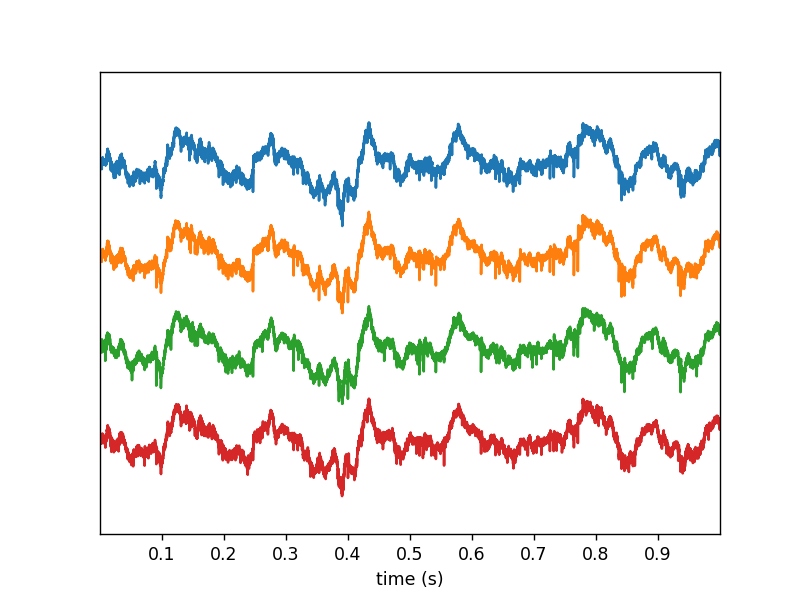

In [9]:
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [10]:
import probeinterface as pi
from probeinterface import plotting

In [11]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [12]:
pi.get_available_pathways()

['H32>RHD2132', 'ASSY-156>RHD2164', 'ASSY-77>Adpt.A64-Om32_2x-sm>RHD2164']

In [13]:
probe.wiring_to_device('ASSY-156>RHD2164')

<IPython.core.display.Javascript object>


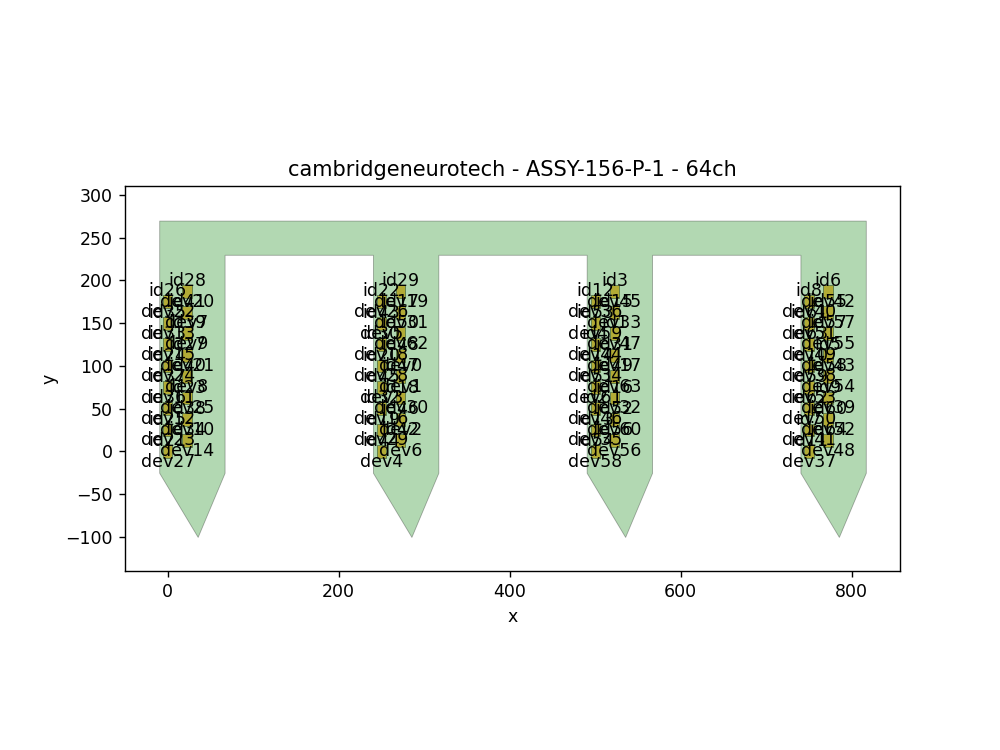

(<matplotlib.collections.PolyCollection at 0x7fa588818580>,
 <matplotlib.collections.PolyCollection at 0x7fa58879df40>)

In [14]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [15]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


Note that also the `shank_id` is loaded with the probe.

**NEW:** A `probeinterface` object can be loaded directly to a SI recording object:

In [16]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [17]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,48,1,0
1,47,1,1
2,46,1,2
3,45,1,3
4,44,1,4
...,...,...,...
59,53,2,59
60,52,2,60
61,51,2,61
62,50,1,62


In [18]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [19]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [20]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

In [21]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [22]:
recording_prb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [23]:
recording_prb.set_property(key='quality', values=["good"]*(recording_prb.get_num_channels() - 3),
                           ids=recording_prb.get_channel_ids()[:-3])

In [24]:
recording_prb.get_property("quality")

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', '', '', ''], dtype='<U4')

In [25]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [26]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [27]:
recording_prb.annotate(description="Dataset for SI 0.90 tutorial")

# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [66]:
# SPLIT AT THE BEGINNING! All for one shank
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [60]:
recording_to_process = recordings_by_group[0]

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below, we bandpass filter the recording and apply common median reference to the original recording:

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


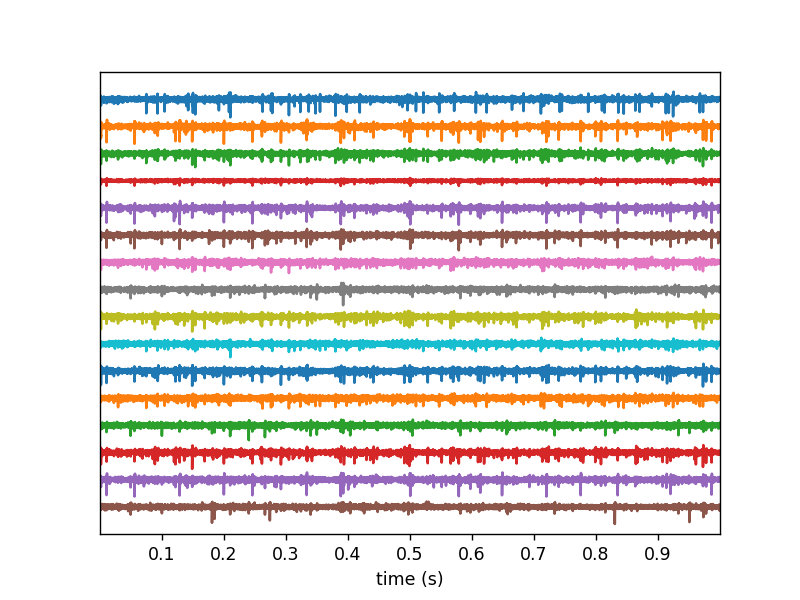

In [62]:
recording_f = st.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

We can see that the after filtering we can observe spyking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

For examplem let's apply Common Median Reference (CMR)

In [63]:
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can plot the traces after removing the bad channel and applying CMR:

<IPython.core.display.Javascript object>


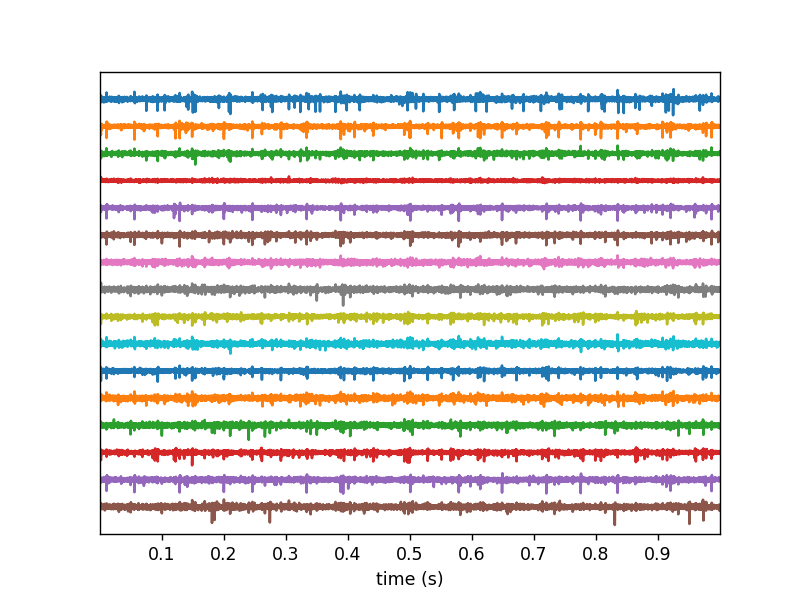

In [64]:
w = sw.plot_timeseries(recording_cmr)

Since we are going to spike sort the data, let's first cut out a 2-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [71]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [86]:
recording_saved = recording_sub.save(folder="preprocessed", progress_bar=True, 
                                     n_jobs=1, total_memory="100M")

write_binary_recording with n_jobs 1  chunk_size 3125000


write_binary_recording: 100%|##########| 2/2 [00:07<00:00,  3.89s/it]


If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [87]:
!ls preprocessed/

cached.json            properties             traces_cached_seg0.raw
probe.json             provenance.json


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

In [88]:
!cat preprocessed/provenance.json

{
    "class": "spikeinterface.core.frameslicerecording.FrameSliceRecording",
    "module": "spikeinterface",
    "kwargs": {
        "parent_recording": {
            "class": "spikeinterface.toolkit.preprocessing.common_reference.CommonReferenceRecording",
            "module": "spikeinterface",
            "kwargs": {
                "recording": {
                    "class": "spikeinterface.toolkit.preprocessing.filter.BandpassFilterRecording",
                    "module": "spikeinterface",
                    "kwargs": {
                        "recording": {
                            "class": "spikeinterface.core.channelslicerecording.ChannelSliceRecording",
                            "module": "spikeinterface",
                            "kwargs": {
                                "parent_recording": {
                                    "class": "spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor",
                                    "module": "spikeint

In [89]:
!cat preprocessed/cached.json

{
    "class": "spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor",
    "module": "spikeinterface",
    "kwargs": {
        "files_path": [
            "traces_cached_seg0.raw"
        ],
        "sampling_frequency": 20000,
        "num_chan": 16,
        "dtype": "<f4",
        "channel_ids": [
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            20,
            21,
            22,
            23,
            24,
            25,
            27
        ],
        "time_axis": 0,
        "file_offset": 0,
        "gain_to_uV": [
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195
        ],
        "offset_to_uV": [
     

As you can see by inspecting the files, the `provenance.json` contains all the information anout the `recording_sub` object (started off as a `BinaryRecording` and had a bandpass filter, a CMR, and a frame slice operation applied to it). The `cached.json` instead directly points to the `traces_cached_seg0.raw` file.

The `properties` folder stores all the properties in `.npy` format:

In [77]:
!ls preprocessed/properties/

brain_area.npy     gain_to_uV.npy     location.npy       quality.npy
contact_vector.npy group.npy          offset_to_uV.npy


The `save` returns a new *cached* recording that has all the previously loaded information:

In [90]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [92]:
recording_loaded = si.load_extractor("preprocessed/")

In [93]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after loading: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<IPython.core.display.Javascript object>


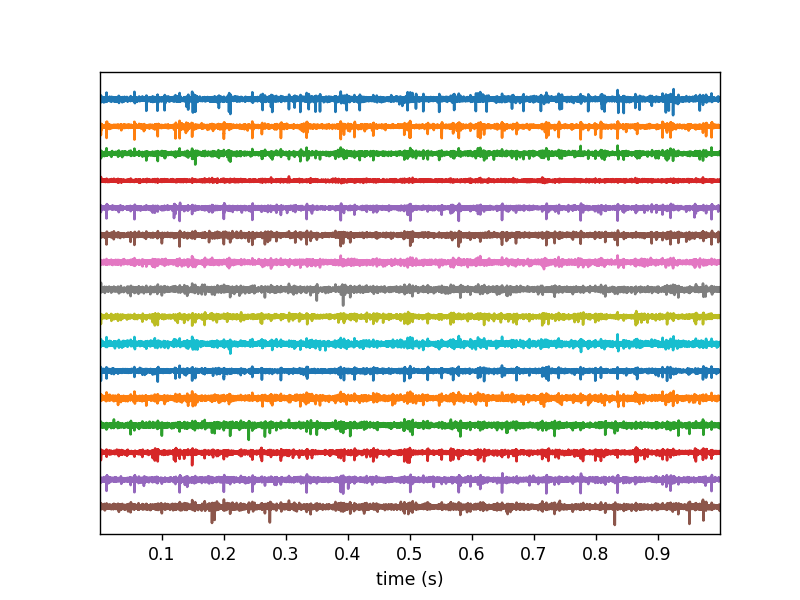

In [81]:
w = sw.plot_timeseries(recording_saved)

We can double check that the traces are exactly the same as the `recording_sub` that we saved:

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


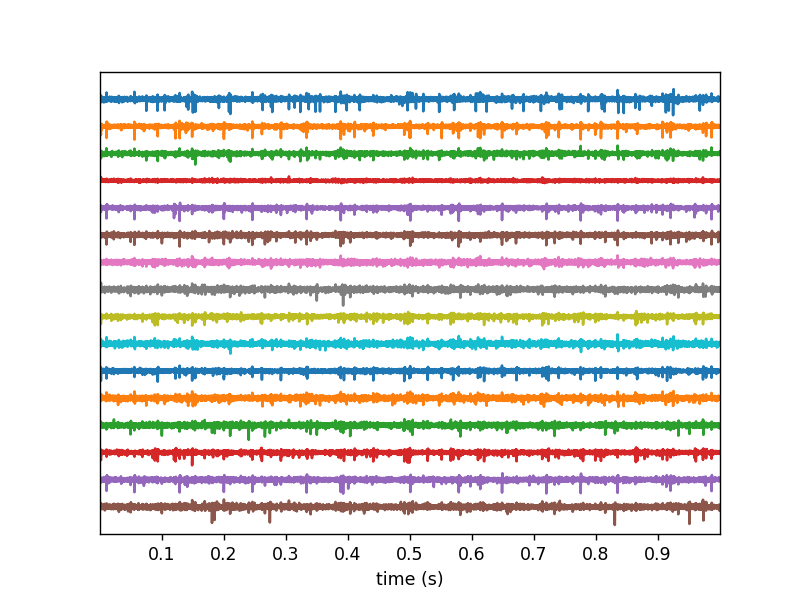

In [82]:
w = sw.plot_timeseries(recording_sub)

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use `herdingspikes` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if herdingspikes is available. Then we can then check the `herdingspikes` default parameters.
We will sort the bandpass cached filtered recording the `recoridng_saved` object.

In [47]:
ss.installed_sorters()

['hdsort',
 'herdingspikes',
 'ironclust',
 'mountainsort4',
 'spykingcircus',
 'tridesclous']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [48]:
ss.get_default_params('herdingspikes')

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 't_inc': 100000,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [49]:
ss.get_params_description('ironclust')

{'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'detect_threshold': 'detection threshold',
 'prm_template_name': '.prm template file name',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'merge_thresh': 'Threshold for automated merging',
 'pc_per_chan': 'Number of principal components per channel',
 'whiten': 'Whether to do channel whitening as part of preprocessing',
 'filter_type': 'Filter type: none, bandpass, wiener, fftdiff, ndiff',
 'filter_detect_type': 'Filter type for detection: none, bandpass, wiener, fftdiff, ndiff',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'step_sec_drift': 'Compute anatomic

In [50]:
ss.run_sorter?

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
ss.run_herdingspikes?

We will set the `filter` to False as the recording is already preprocessed:

In [94]:
# run spike sorting on entire recording
sorting_HS_all = ss.run_herdingspikes(recording_saved, output_folder='results_hs', filter=False, verbose=True)
print('Found', len(sorting_IC_all.get_unit_ids()), 'units')

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Herdingspikes use the OLD spikeextractors with RecordingExtractorOldAPI
# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 20000
# Localization On
# Number of recorded channels: 16
# Analysing frames: 6000000; Seconds: 300.0
# Frames before spike in cutout: 6
# Frames after spike in cutout: 36
# tcuts: 26 56
# tInc: 100000
# Analysing frames from -26 to 100056  (0.0%)
# Analysing frames from 99974 to 200056  (1.7%)
# Analysing frames from 199974 to 300056  (3.3%)
# Analysing frames from 299974 to 400056  (5.0%)
# Analysing frames from 399974 to 500056  (6.7%)
# Analysing frames from 499974 to 600056  (8.3%)
# Analysing frames from 599974 to 700056  (10.0%)
# Analysing frames from 699974 to 800056  (11.7%)
# Analysing frames from 799974 to 900056  (13.3%)
# Analysing frames from 899974 to 1000056  (15.0%)
# Analysing frames from 999974 to 1100056  (16.7%)
# Analysing frames from 1099974 to 1200056  (18.3%)
# Analysing frames from 1199

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   10.5s remaining:   17.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   10.5s finished
/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/herdingspikes/clustering/mean_shift_.py:242: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unique = np.ones(len(sorted_centers), dtype=np.bool)
/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/herdingspikes/clustering/mean_shift_.py:255: DeprecationWarning: `np.int` is a deprecated alias for 

Number of estimated units: 19
Saving to results_hs/HS2_sorted.hdf5
herdingspikes run time 14.05s
Found 74 units


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [95]:
!git clone https://github.com/flatironinstitute/ironclust

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cloning into 'ironclust'...
remote: Enumerating objects: 4964, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.


Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [96]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Setting IRONCLUST_PATH environment variable for subprocess calls to: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/ironclust


Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [97]:
ss.IronClustSorter.ironclust_path

'/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/ironclust'

In [98]:
!echo $IRONCLUST_PATH

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/ironclust


In [99]:
ss.installed_sorters()

['hdsort',
 'herdingspikes',
 'ironclust',
 'mountainsort4',
 'spykingcircus',
 'tridesclous']

In [101]:
# run spike sorting by group
sorting_IC = ss.run_ironclust(recording_saved, 
                              output_folder='results_IC',
                              verbose=True)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Warning! The recording is already filtered, but ironclust filter is enabled
write_binary_recording with n_jobs 1  chunk_size 7812500
channels = 16, timepoints = 6000000, duration = 5.0 minutes
Creating argfile.txt...
Running ironclust in /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/results_IC/tmp...
RUNNING SHELL SCRIPT: results_IC/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019





                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathwor


    Feature extracted:      gpca

    Feature extracted:      gpca

    #Sites/event:           12

    #Sites/event:           12

    maxDist_site_um:        50

    maxDist_site_um:        50

    maxDist_site_spk_um:    100

    maxDist_site_spk_um:    100

    spkLim_ms:              [-0.250, 0.750]

    spkLim_ms:              [-0.250, 0.750]

    #PC/chan:               9

    #PC/chan:               9

Cluster

Cluster

    #Clusters:              27

    #Clusters:              27

    #Unique events:         105081

    #Unique events:         105081

    min. spk/clu:           30

    min. spk/clu:           30

    Cluster method:         drift-knn

    Cluster method:         drift-knn

    knn:                    30

    knn:                    30

    step_sec_drift:         20.0s

    step_sec_drift:         20.0s

    batch_sec_drift:        300.0s

    batch_sec_drift:        300.0s

Auto-merge

Auto-merge

    merge_overlap_thresh:   0.950

    merge_overlap_thresh

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/sorters/basesorter.py:204: ResourceWarning: unclosed file <_io.TextIOWrapper name=98 encoding='UTF-8'>
  SorterClass._run_from_folder(output_folder, sorter_params, verbose)


ironclust run time 98.17s
IronClust found 28 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [102]:
print(f'Ironclust unit ids: {sorting_IC.get_unit_ids()}')

Ironclust unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [103]:
print(f'Spike train of a unit: {sorting_IC.get_unit_spike_train(13)}')

Spike train of a unit: [   6994  290608  293874  304012  305086  331726  501586  508638  511016
  546049  607026  609344  848726  927312  929640  930833  933740  949082
  950940  958437  960368  967620  970551  976376  987431  996282 1000870
 1242947 1432301 1544716 1547598 1866829 1873398 1875627 2052903 2067783
 2143588 2177179 2185439 2186827 2194250 2209351 2211428 2490757 2660958
 2662367 2665221 3074986 3096649 3099799 3100920 3101275 3103804 3105309
 3117337 3118654 3120832 3124591 3127412 3129695 3132205 3133236 3137165
 3138709 3140783 3142621 3144799 3147571 3148694 3151559 3153349 3154226
 3163834 3165970 3167232 3169285 3170065 3172412 3173669 3175530 3178692
 3179945 3188621 3191151 3193940 3194987 3197109 3199223 3200528 3202854
 3210667 3211234 3213252 3220613 3222804 3224271 3225138 3227697 3237635
 3240492 3290659 3293238 3640764 3644837 3646725 3653454 3656178 3667195
 3671127 3692246 3757707 3787663 3792104 3794567 3808880 3842907 3906133
 3907864 3909876 3916756 397

We can use `spikewidgets` functions to quickly visualize some unit features:

<IPython.core.display.Javascript object>


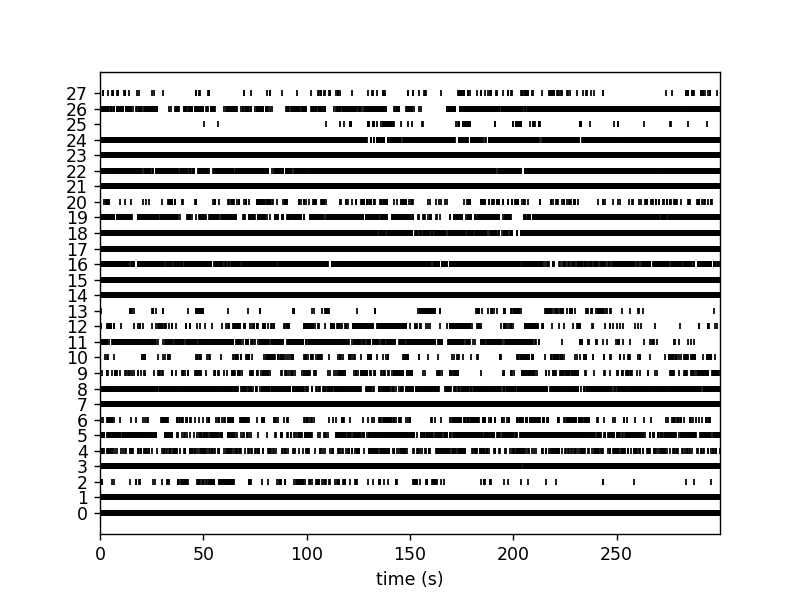

In [105]:
w_rs = sw.plot_rasters(sorting_IC)

# Running multiple sorter jobs in parallel

So far we have seen how to lanch one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [110]:
sorting_outputs = ss.run_sorters(sorter_list=["herdingspikes", "ironclust"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder="all_sorters2",
                                 verbose=True,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 2})

{'group0': BinaryRecordingExtractor: 16 channels - 1 segments - 20.0kHz - 300.000s
  files_path: ['/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_new_API/preprocessed/traces_cached_seg0.raw']}
<class 'spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor'>
<class 'spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor'>


The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [112]:
print(sorting_outputs.keys())

dict_keys([('group0', 'herdingspikes'), ('group0', 'ironclust')])


For the rest of the tutorial, let's pick the `ironclust` output:

In [113]:
sorting_IC = sorting_outputs[('group0', 'ironclust')]

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing revolves around extracting waveforms from paired recording-sorting objects.

**NEW** In the new SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [119]:
we = si.extract_waveforms(recording_saved, sorting_IC, folder="wf_IC", progress_bar=True)
print(type(we))

extract waveforms: 100%|##########| 1/1 [00:00<00:00,  6.11it/s]


<class 'spikeinterface.core.waveform_extractor.WaveformExtractor'>


Now all waveforms are computed and stored in the provided `wf_IC` folder. We can now retrieve waveforms and templates easily:

In [124]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms.shape}")
template = we.get_template(unit_id=0)
print(f"Template shape: {template.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 140, 16)
Template shape: (140, 16)
All templates shape: (28, 140, 16)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


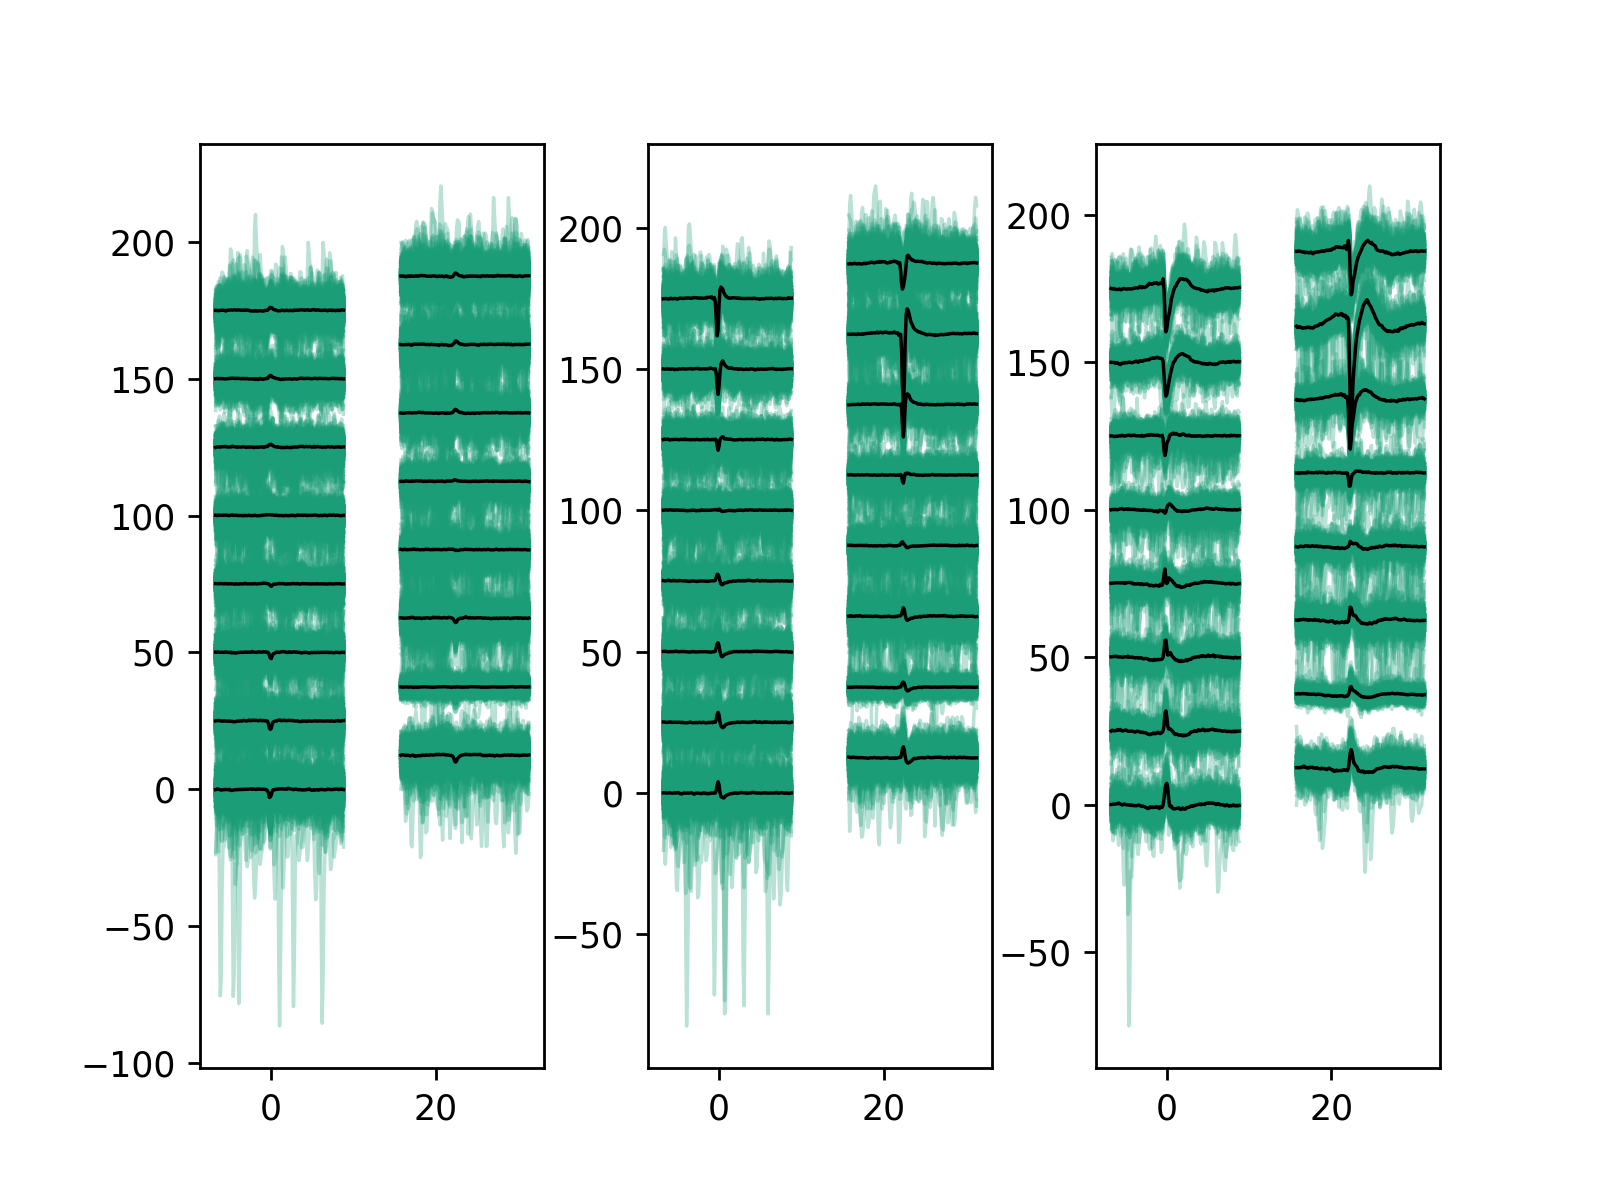

<IPython.core.display.Javascript object>


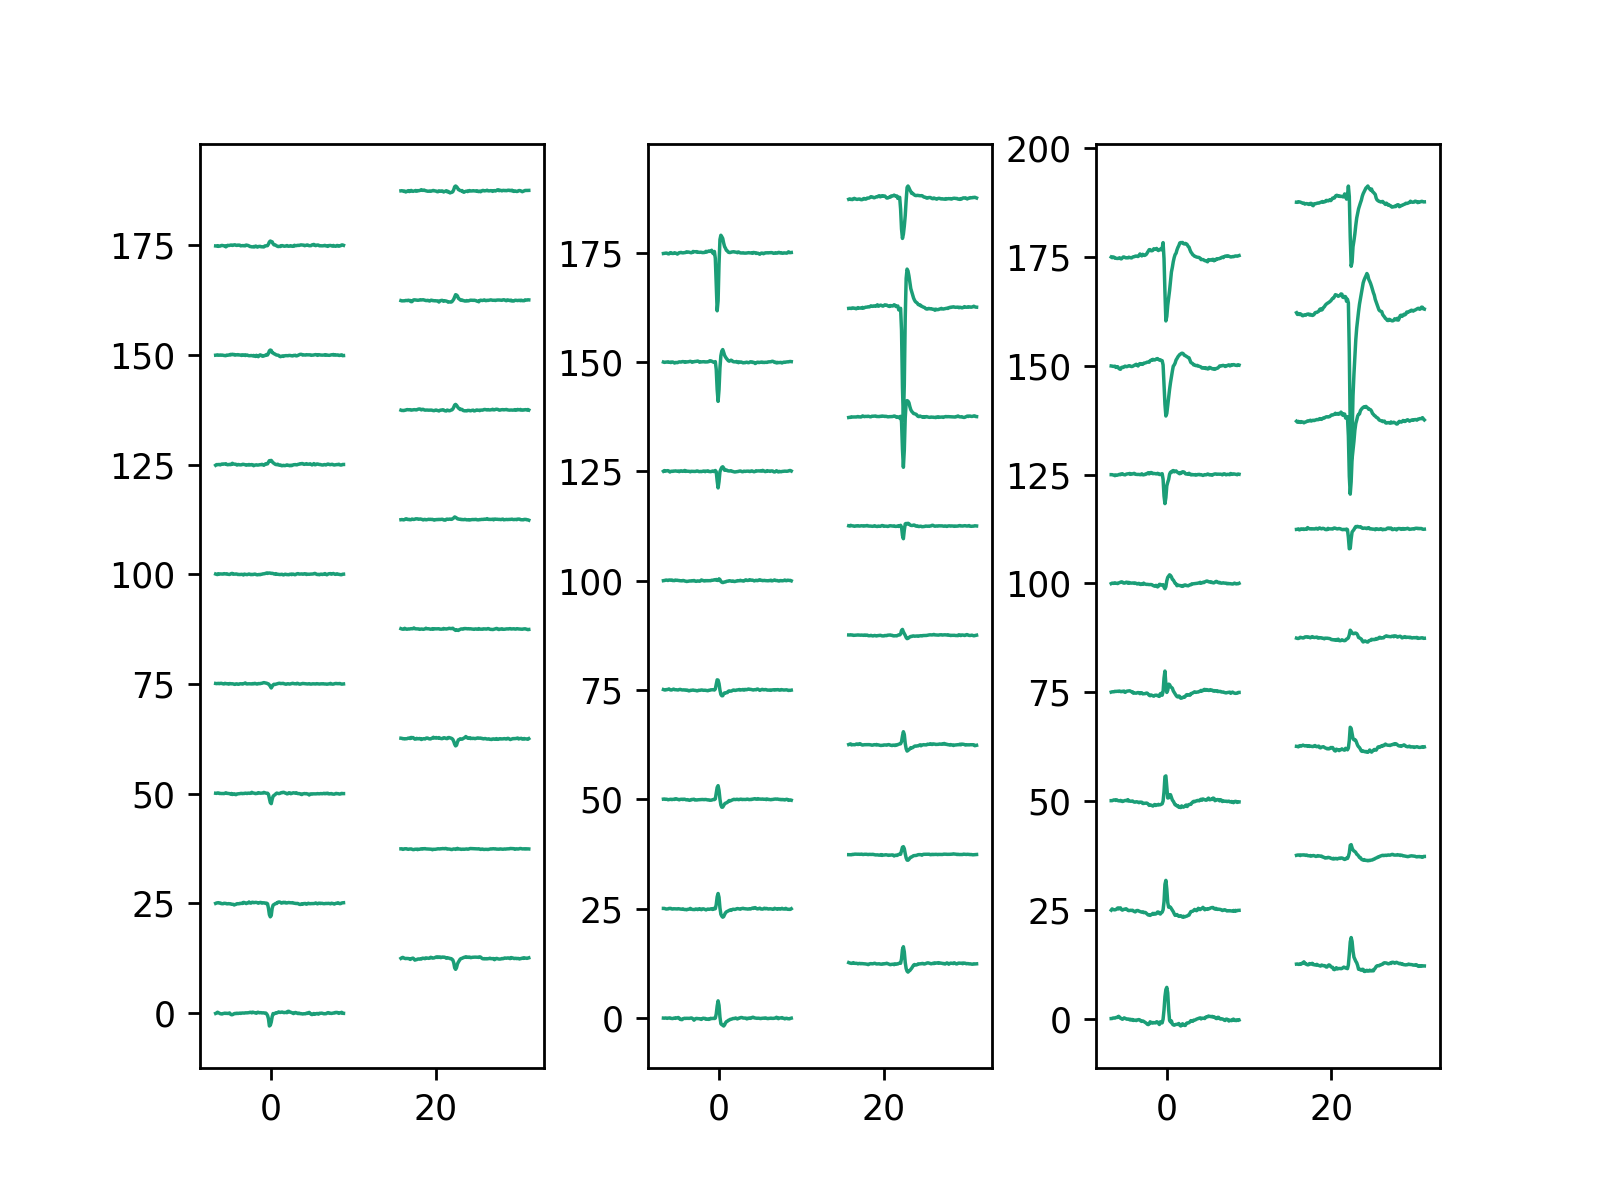

<IPython.core.display.Javascript object>


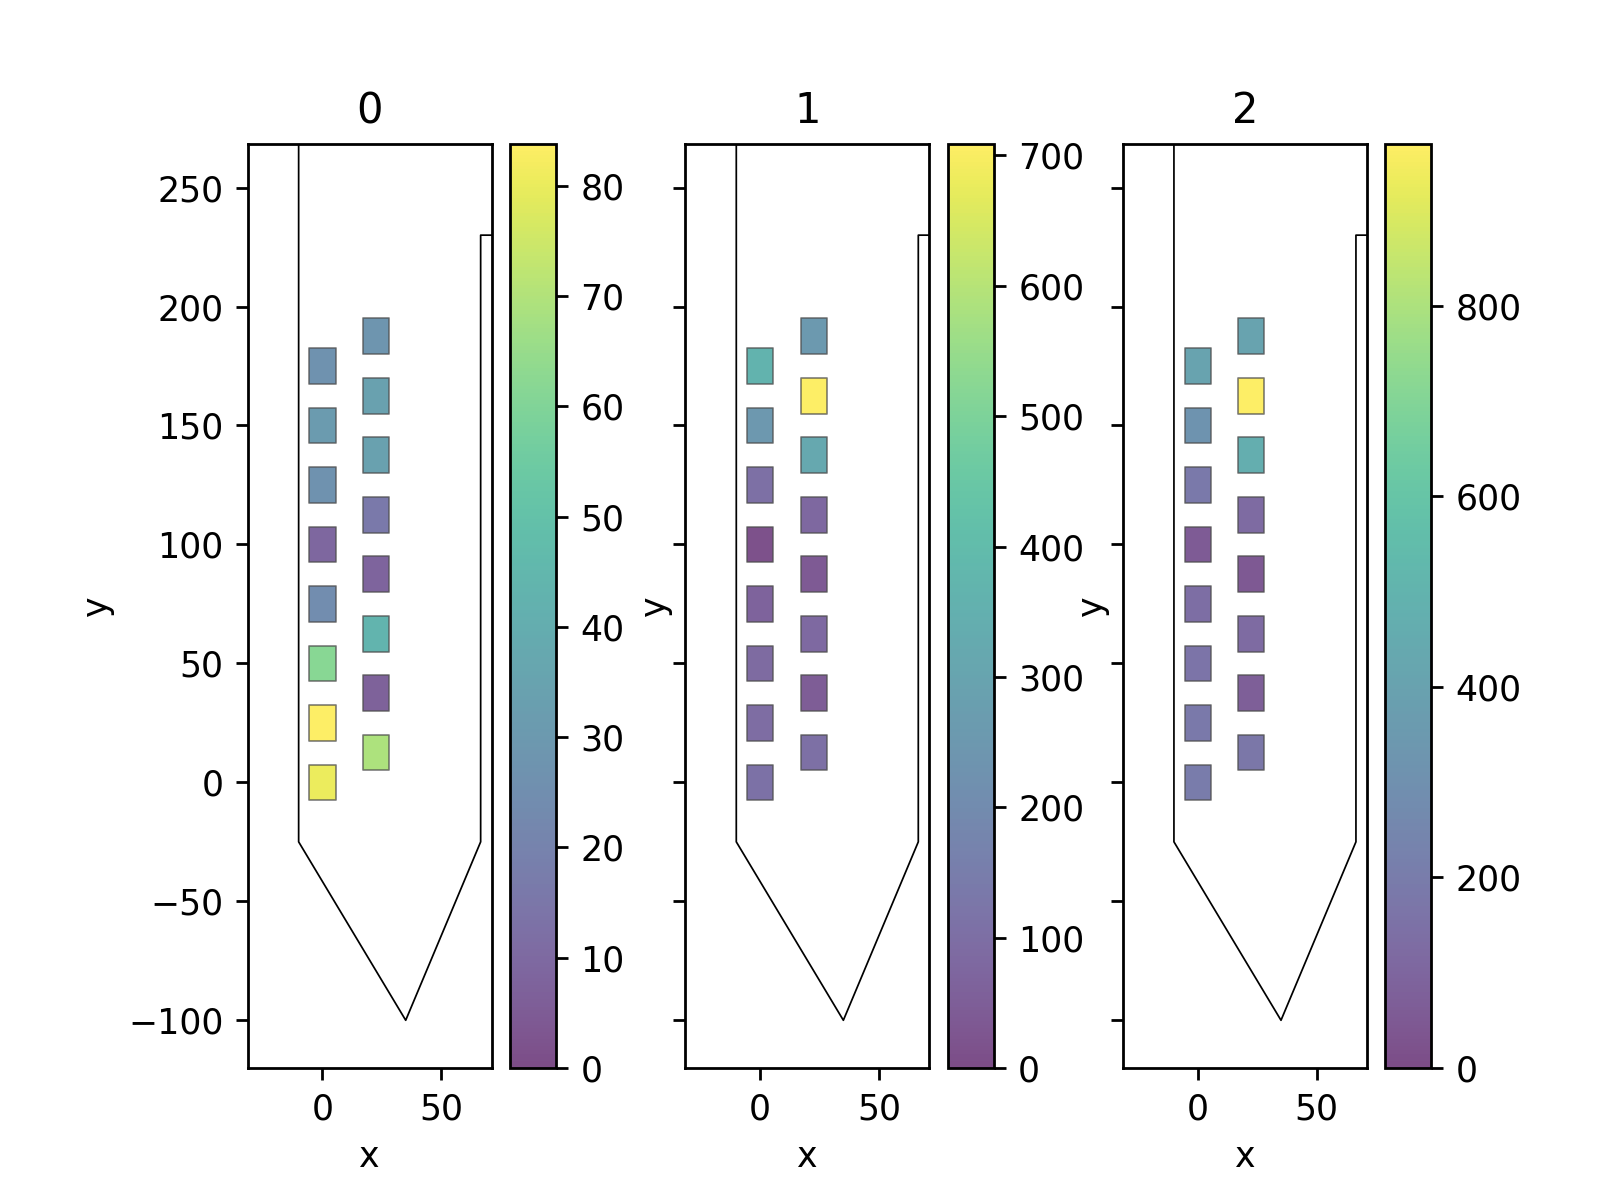

In [131]:
w = sw.plot_unit_waveforms(we, unit_ids=[0,1,2])
w = sw.plot_unit_templates(we, unit_ids=[0,1,2])
w = sw.plot_unit_probe_map(we, unit_ids=[0,1,2])

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [137]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 45392 - num spikes: 45392
Unit 1 - num waveforms: 8310 - num spikes: 8310
Unit 2 - num waveforms: 236 - num spikes: 236
Unit 3 - num waveforms: 4608 - num spikes: 4608
Unit 4 - num waveforms: 482 - num spikes: 482
Unit 5 - num waveforms: 1606 - num spikes: 1607
Unit 6 - num waveforms: 439 - num spikes: 439
Unit 7 - num waveforms: 7773 - num spikes: 7773
Unit 8 - num waveforms: 1643 - num spikes: 1643
Unit 9 - num waveforms: 532 - num spikes: 532
Unit 10 - num waveforms: 335 - num spikes: 335
Unit 11 - num waveforms: 918 - num spikes: 918
Unit 12 - num waveforms: 595 - num spikes: 595
Unit 13 - num waveforms: 203 - num spikes: 203
Unit 14 - num waveforms: 6318 - num spikes: 6318
Unit 15 - num waveforms: 4437 - num spikes: 4437
Unit 16 - num waveforms: 2381 - num spikes: 2381
Unit 17 - num waveforms: 28488 - num spikes: 28488
Unit 18 - num waveforms: 3174 - num spikes: 3175
Unit 19 - num waveforms: 2109 - num spikes: 2109
Unit 20 - num waveforms: 412 - num spikes:

No units have mor than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [134]:
we_all = si.extract_waveforms(recording_saved, sorting_IC, folder="wf_IC_all", 
                              max_spikes_per_unit=None, progress_bar=True)

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
extract waveforms: 100%|##########| 1/1 [00:08<00:00,  8.71s/it]


In [138]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 45392 - num spikes: 45392
Unit 1 - num waveforms: 8310 - num spikes: 8310
Unit 2 - num waveforms: 236 - num spikes: 236
Unit 3 - num waveforms: 4608 - num spikes: 4608
Unit 4 - num waveforms: 482 - num spikes: 482
Unit 5 - num waveforms: 1606 - num spikes: 1607
Unit 6 - num waveforms: 439 - num spikes: 439
Unit 7 - num waveforms: 7773 - num spikes: 7773
Unit 8 - num waveforms: 1643 - num spikes: 1643
Unit 9 - num waveforms: 532 - num spikes: 532
Unit 10 - num waveforms: 335 - num spikes: 335
Unit 11 - num waveforms: 918 - num spikes: 918
Unit 12 - num waveforms: 595 - num spikes: 595
Unit 13 - num waveforms: 203 - num spikes: 203
Unit 14 - num waveforms: 6318 - num spikes: 6318
Unit 15 - num waveforms: 4437 - num spikes: 4437
Unit 16 - num waveforms: 2381 - num spikes: 2381
Unit 17 - num waveforms: 28488 - num spikes: 28488
Unit 18 - num waveforms: 3174 - num spikes: 3175
Unit 19 - num waveforms: 2109 - num spikes: 2109
Unit 20 - num waveforms: 412 - num spikes:

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `toolkit` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [141]:
pc = st.compute_principal_components(we, n_components=3)

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [144]:
pc0 = pc.get_components(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_components()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (45392, 3, 16)
All PC scores shape: (150470, 3, 16)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

Spike amplitudes can be computed with the `compute_amplitudes` function.

In [147]:
amplitudes = st.get_unit_amplitudes(we, outputs="concatenated", progress_bar=True)

extract amplitudes: 100%|##########| 1/1 [00:00<00:00,  5.29it/s]


In [151]:
len(amplitudes[0])

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


150473

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [154]:
print(st.get_template_metric_names())

AttributeError: module 'spikeinterface.toolkit' has no attribute 'get_template_metric_names'

In [158]:
template_metrics = st.calculate_template_metrics(we_all)
display(template_metrics)

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.00075,-0.079558,0.0002,342480.892931,-8725.410744
1,0.0002,-0.329844,0.0002,6544028.85437,-351658.033853
2,0.00085,-0.244586,0.00025,2383070.342382,-362449.767354
3,0.00065,-0.276835,0.0003,754087.380682,-98834.695208
4,0.0007,-0.206789,0.0002,628875.256947,-56937.776754
5,0.0006,-0.294159,0.0003,2120510.809876,-285891.38358
6,0.0006,-0.30703,None,1766601.943516,-251462.4835
7,0.00025,-0.272736,0.0002,1952722.396851,-93838.607075
8,0.00065,-0.308376,0.0003,739440.142087,-109589.701768
9,0.00065,-0.269248,0.0002,1910881.159306,-235224.358695


/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


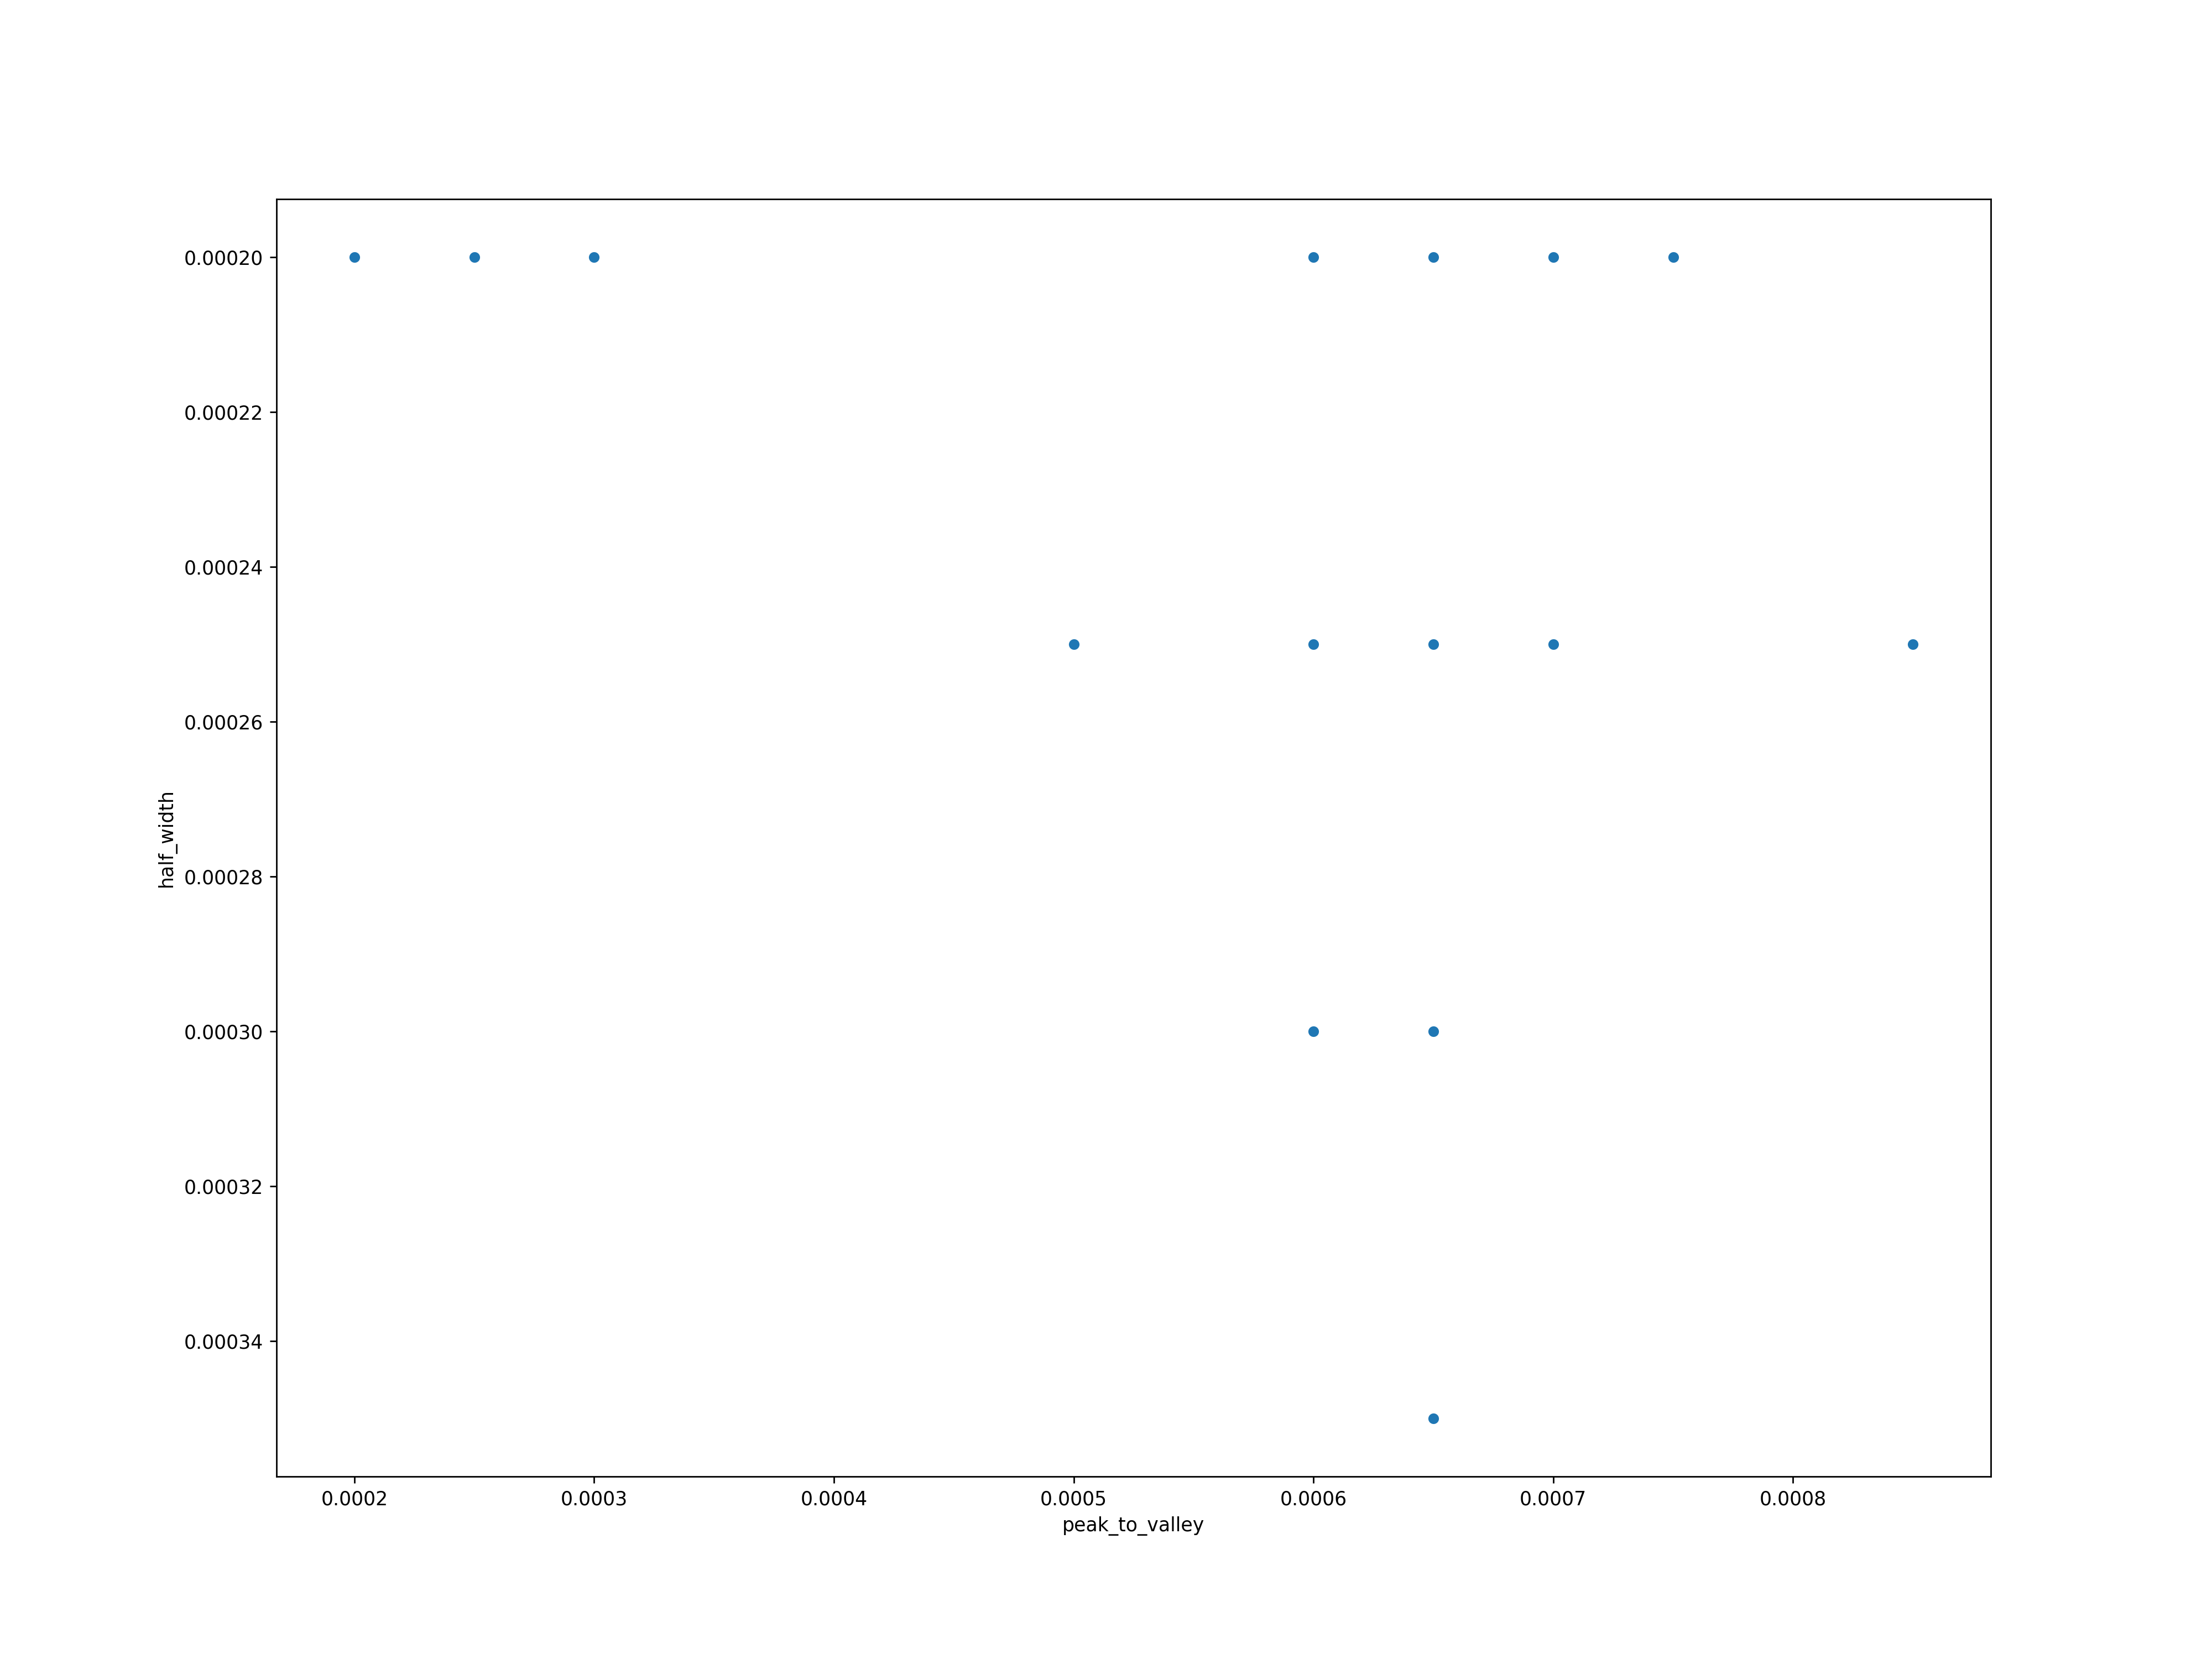

<AxesSubplot:xlabel='peak_to_valley', ylabel='half_width'>

In [162]:
plt.figure()
sns.scatterplot(data=template_metrics, x="peak_to_valley", y="half_width")

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics about the spike sorting results.

Let's see what metrics are available:

In [ ]:
print(st.get_quality_metric_list())

In [171]:
qc = st.compute_quality_metrics(we_all, waveform_principal_component=pc)

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/toolkit/qualitymetrics/pca_metrics.py:174: DeprecationWarning: invalid escape sequence \s
  


<class 'spikeinterface.toolkit.postprocessing.principal_component.WaveformPrincipalComponent'>


In [173]:
display(qc)

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,num_spikes,firing_rate,presence_ratio,snr,isi_violations_rate,isi_violations_count,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate
0,45392,151.306667,1.00,1.144578,36.860000,11058,0.000044,51.991388,0.829104,1.278719,0.596596,0.198501
1,8310,27.700000,1.00,8.261319,0.106667,32,0.000031,70.588634,0.223069,6.365983,0.825483,0.005222
2,236,0.786667,0.59,13.594438,0.000000,0,0.001097,83.865128,0.013972,8.135910,0.888889,0.000100
3,4608,15.360000,1.00,5.381992,0.103333,31,0.003711,40.211502,3.200521,2.794407,0.399782,0.013342
4,482,1.606667,1.00,3.566879,0.010000,3,0.016999,23.641259,57.641883,1.566815,0.010417,0.003010
5,1607,5.356667,0.99,14.137097,0.010000,3,0.000161,58.307480,0.514538,5.905549,0.779874,0.001550
6,439,1.463333,0.85,13.427127,0.000000,0,0.016789,47.040565,3.022579,4.160950,0.425287,0.000802
7,7773,25.910000,1.00,3.690492,0.480000,144,0.000033,36.425293,3.490458,1.788510,0.306202,0.046886
8,1643,5.476667,1.00,5.266602,0.030000,9,0.000158,34.191322,8.617633,2.589027,0.293578,0.008088
9,532,1.773333,0.86,10.223854,0.000000,0,0.000488,48.984368,1.804740,5.512923,0.257143,0.001037


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Curation

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

# HEREEEE

In [175]:
from spikeinterface.exporters import export_to_phy

/Users/abuccino/anaconda3/envs/si2/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
export_to_phy(recording_saved, 
              sorting_IC, output_folder='phy_IC',
              grouping_property='group', verbose=True, recompute_info=True, n_jobs=4)

In [ ]:
%%capture --no-display
!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [ ]:
sorting_IC_phy_curated = se.PhySortingExtractor('phy_IC/', exclude_cluster_groups=['noise'])

In [ ]:
print(len(sorting_IC_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_IC_phy_curated.get_unit_ids()}")

In [ ]:
# We can do the same for the klusta output.
# st.postprocessing.export_to_phy(recording_cache, 
#                                 sorting_KL, output_folder='phy_KL',
#                                 grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
# %%capture --no-display
# !phy template-gui phy_KL/params.py

### 2) Automatic curation based on quality metrics

In [ ]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [ ]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

In [ ]:
len(sorting_auto.get_unit_ids())

In [ ]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording_cache, snr_thresh, 'less')

In [ ]:
len(sorting_auto.get_unit_ids())

# 8. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

In [ ]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'], spiketrain_mode='union',
                                   verbose=True)

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
agreement_sorting.get_unit_ids()

In [ ]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_IC_phy_curated, agreement_sorting)

In [ ]:
w_agr = sw.plot_agreement_matrix?

In [ ]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr, unit_ticks=False, count_text=False)

In [ ]:
st.postprocessing.export_to_phy(recording_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

## Save to / load from NWB

In [ ]:
metadata = {}
metadata["NWBFile"] = {"session_description": "Test data for webinar."}

In [ ]:
se.NwbRecordingExtractor.write_recording

In [ ]:
se.NwbRecordingExtractor.write_recording(recording_loaded, 'si_tutorial2.nwb', metadata=metadata, overwrite=True)

In [ ]:
se.NwbSortingExtractor.write_sorting(sorting_IC, 'si_tutorial.nwb')

In [ ]:
recording_nwb = se.NwbRecordingExtractor('si_tutorial.nwb')
sorting_nwb = se.NwbSortingExtractor('si_tutorial.nwb')

In [ ]:
sorting_nwb.get_shared_unit_property_names()